In [1]:
# Python Libraries
import numpy as np
from scipy import stats
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import missingno as msno
import seaborn as sns
from datetime import date,datetime, timedelta
import os
import requests
import json

import warnings
warnings.filterwarnings('ignore') 

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Conforming vs Jumbo loans
1. What is the conversion rate from loan application to fund, broken down by conforming vs jumbo?
2. How does it vary over time?
3. How much worse is the conversion rate for jumbo, controlling for the loan amount?
4. What about states? Are there particular states where it looks like our Jumbo has much worse conversion?

In [3]:
loan_limits = pd.read_excel("data/FullCountyLoanLimitList2017_HERA-BASED_FINAL_FLAT.xlsx", header=1)

In [4]:
loan_limits.head()

,FIPS State Code,FIPS County Code,County Name,State,CBSA Number,One-Unit Limit,Two-Unit Limit,Three-Unit Limit,Four-Unit Limit
0,1,1,AUTAUGA,AL,33860.000,424100,543000,656350,815650
1,1,3,BALDWIN,AL,19300.000,424100,543000,656350,815650
2,1,5,BARBOUR,AL,nan,424100,543000,656350,815650
3,1,7,BIBB,AL,13820.000,424100,543000,656350,815650
4,1,9,BLOUNT,AL,13820.000,424100,543000,656350,815650


In [5]:
df = pd.read_csv("data/gps_loan.csv", sep=",")
df.head()

,Unnamed: 0,amount,address,created,funded,conversion_length_m,conversion_length_d,state_code,county_code
0,1,413165.000,"124 Vignolia Court, Roseville CA 95747",2016-10-11,2016-11-07,0.887,27.000,6,61
1,6,504193.000,"10190 Brixton Pl, Suwanee GA 30024",2017-08-18,2017-09-18,1.019,31.000,13,117
2,8,275236.000,"1952 S St SE, Washington DC 20020",2017-09-23,2017-11-15,1.741,53.000,11,1
3,37,287472.000,"7498 NE 156th St, Kenmore WA 98028",2016-11-21,2016-12-30,1.281,39.000,53,33
4,40,254942.000,"3212-3214 W 157th St, Gardena CA 90249",2016-10-01,2016-11-18,1.577,48.000,6,37


In [6]:
df.state_code.unique()

array([ 6, 13, 11, 53,  4, 41, 34,  8, 42, 17, 12, 37,  9])

In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
merge_df= pd.merge(loan_limits, df, how="inner", left_on=["FIPS State Code","FIPS County Code"], right_on=["state_code", "county_code"])

In [9]:
loan_limits.columns

Index(['FIPS State Code', 'FIPS County Code', 'County Name', 'State',
       'CBSA Number', 'One-Unit Limit', 'Two-Unit Limit', 'Three-Unit Limit',
       'Four-Unit Limit'],
      dtype='object')

In [10]:
merge_df.drop(["FIPS State Code", "FIPS County Code", "CBSA Number"], axis=1, inplace=True)

In [11]:
merge_df.head()

,County Name,State,One-Unit Limit,Two-Unit Limit,Three-Unit Limit,Four-Unit Limit,amount,address,created,funded,conversion_length_m,conversion_length_d,state_code,county_code
0,COCONINO,AZ,424100,543000,656350,815650,361934.000,"2000 N Rio De Flag Dr, Flagstaff AZ 86004",2017-09-26,2017-11-27,2.037,62.000,4,5
1,MARICOPA,AZ,424100,543000,656350,815650,244251.000,"21109 N 98th Ave, Peoria AZ 85382",2017-10-09,2017-11-21,1.413,43.000,4,13
2,MARICOPA,AZ,424100,543000,656350,815650,307000.000,"1905-1915 W Cambridge Ave, Phoenix AZ 85009",2017-06-18,2017-07-21,1.084,33.000,4,13
3,MARICOPA,AZ,424100,543000,656350,815650,394436.000,"2816 E Dennisport Ct, Gilbert AZ 85295",2017-10-14,2017-11-21,1.248,38.000,4,13
4,MARICOPA,AZ,424100,543000,656350,815650,226588.000,"2240 N Scottsdale Rd, Tempe AZ 85281",2017-10-04,2017-12-01,1.906,58.000,4,13


# We breakdown by unit limit.

In [12]:
merge_df["jumbo_one_unit"] = np.where(merge_df["amount"] > merge_df["One-Unit Limit"], True, False)
merge_df["jumbo_two_unit"] = np.where(merge_df["amount"] > merge_df["Two-Unit Limit"], True, False)
merge_df["jumbo_three_unit"] = np.where(merge_df["amount"] > merge_df["Three-Unit Limit"], True, False)
merge_df["jumbo_four_unit"] = np.where(merge_df["amount"] > merge_df["Four-Unit Limit"], True, False)

In [13]:
merge_df = merge_df[["amount","address", "County Name", "State", "created", "funded", "conversion_length_d", 
         "jumbo_one_unit", "jumbo_two_unit", "jumbo_three_unit","jumbo_four_unit"]]
merge_df.head()

,amount,address,County Name,State,created,funded,conversion_length_d,jumbo_one_unit,jumbo_two_unit,jumbo_three_unit,jumbo_four_unit
0,361934.000,"2000 N Rio De Flag Dr, Flagstaff AZ 86004",COCONINO,AZ,2017-09-26,2017-11-27,62.000,False,False,False,False
1,244251.000,"21109 N 98th Ave, Peoria AZ 85382",MARICOPA,AZ,2017-10-09,2017-11-21,43.000,False,False,False,False
2,307000.000,"1905-1915 W Cambridge Ave, Phoenix AZ 85009",MARICOPA,AZ,2017-06-18,2017-07-21,33.000,False,False,False,False
3,394436.000,"2816 E Dennisport Ct, Gilbert AZ 85295",MARICOPA,AZ,2017-10-14,2017-11-21,38.000,False,False,False,False
4,226588.000,"2240 N Scottsdale Rd, Tempe AZ 85281",MARICOPA,AZ,2017-10-04,2017-12-01,58.000,False,False,False,False


# If loan amount is greater to any loan threshold is greater than the lower thresholds.
# Consolidate in one boolean variable "Jumbo" other boolean "jumbo" columns.

In [14]:
merge_df["jumbo"] =np.where(merge_df["jumbo_one_unit"] |  merge_df["jumbo_two_unit"] | 
                            merge_df["jumbo_three_unit"] | merge_df["jumbo_four_unit"], True, False)

In [15]:
merge_df.drop(["jumbo_one_unit", "jumbo_two_unit", "jumbo_three_unit", "jumbo_four_unit"], axis=1,inplace=True)
merge_df.head()

,amount,address,County Name,State,created,funded,conversion_length_d,jumbo
0,361934.000,"2000 N Rio De Flag Dr, Flagstaff AZ 86004",COCONINO,AZ,2017-09-26,2017-11-27,62.000,False
1,244251.000,"21109 N 98th Ave, Peoria AZ 85382",MARICOPA,AZ,2017-10-09,2017-11-21,43.000,False
2,307000.000,"1905-1915 W Cambridge Ave, Phoenix AZ 85009",MARICOPA,AZ,2017-06-18,2017-07-21,33.000,False
3,394436.000,"2816 E Dennisport Ct, Gilbert AZ 85295",MARICOPA,AZ,2017-10-14,2017-11-21,38.000,False
4,226588.000,"2240 N Scottsdale Rd, Tempe AZ 85281",MARICOPA,AZ,2017-10-04,2017-12-01,58.000,False


In [16]:
trend_ts_df = merge_df[["funded","conversion_length_d", "jumbo"]]
trend_ts_df = trend_ts_df.sort_values("funded",ascending=True)
trend_ts_df.set_index("funded", inplace=True)
trend_ts_df.head()

,conversion_length_d,jumbo
funded,,
2016-10-26,30.000,False
2016-10-26,44.000,False
2016-10-26,49.000,False
2016-10-26,62.000,False
2016-10-26,60.000,False


In [17]:
conforming_df = trend_ts_df[~trend_ts_df["jumbo"]]
conforming_df.drop("jumbo", axis=1, inplace=True)
conforming_df.index = pd.to_datetime(conforming_df.index, format="%Y-%m-%d", errors="coerce")
jumbo_df = trend_ts_df[trend_ts_df["jumbo"]]
jumbo_df.drop("jumbo", axis=1, inplace=True)
jumbo_df.index = pd.to_datetime(jumbo_df.index, format="%Y-%m-%d", errors="coerce")
conforming_df.head()

,conversion_length_d
funded,
2016-10-26,30.000
2016-10-26,44.000
2016-10-26,49.000
2016-10-26,62.000
2016-10-26,60.000


In [18]:
jumbo_df.head()

,conversion_length_d
funded,
2017-02-24,39.000
2017-04-24,47.000
2017-07-13,48.000
2017-07-26,38.000
2017-09-18,31.000


In [19]:
conforming_df_conversion_rate = conforming_df.groupby("funded").count()
jumbo_df_conversion_rate = jumbo_df.groupby("funded").count()

In [20]:
print("Mean conforming conversion rate:{:.3f}, Mean jumbo conversion rate:{:.3f}"
      .format(conforming_df_conversion_rate.mean()[0], jumbo_df_conversion_rate.mean()[0]))

Mean conforming conversion rate:3.832, Mean jumbo conversion rate:1.000


# 1. Lower conversion rate for Jumbo vs. Conforming loans.
# 2. Fewer jumbo loans than conforming loans.
# 3. Conforming rate between 5 and 10 with peaks ar 20 in December 2016 and December 2018. 
# 4. Compared to conforming loans, jumbo loans are far fewer.

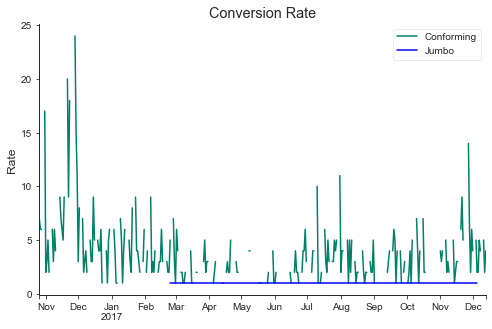

In [21]:
sns.set_style('ticks')
red="#D62728"
blue='#1F77B4'
fig, ax = plt.subplots(figsize=(8,5))
conforming_df_conversion_rate = conforming_df.groupby("funded")["conversion_length_d"].count().resample('D').mean()
conforming_df_conversion_rate.plot(kind='line',colormap='summer')
jumbo_df_conversion_rate = jumbo_df.groupby("funded")["conversion_length_d"].count().resample('D').mean()
jumbo_df_conversion_rate.dropna(inplace=True)
jumbo_df_conversion_rate.plot(kind='line',colormap='winter')
ax.set_xlabel("")
ax.set_ylabel("Rate")
ax.legend(["Conforming", "Jumbo"])
ax.set_title("Conversion Rate")
ax.set_xticks([], minor=True) 
ax.set_xlim([conforming_df_conversion_rate.index[0], conforming_df_conversion_rate.index[-1]])
sns.despine()
plt.show()

# Conversion rate for jumbo loans is 1.

In [22]:
trend_ts_jumbo_df_mean = jumbo_df.groupby("funded").mean()
trend_ts_jumbo_df_mean.head()

,conversion_length_d
funded,
2017-02-24,39.000
2017-04-24,47.000
2017-07-13,48.000
2017-07-26,38.000
2017-09-18,31.000


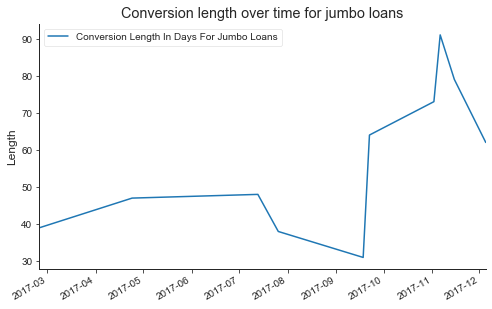

In [23]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8,5))
trend_ts_jumbo_df_mean["conversion_length_d"].plot(color=blue)
ax.set_xlabel("")
ax.set_ylabel("Length")
ax.legend(["Conversion Length In Days For Jumbo Loans"])
ax.set_title("Conversion length over time for jumbo loans")
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

# For jumbo loans the average conversion is length is between 30 and 90.

In [24]:
trend_amount_df = merge_df[["amount","funded", "conversion_length_d", "jumbo"]]
trend_amount_df = trend_amount_df.sort_values("funded",ascending=True)
trend_amount_df.set_index("funded", inplace=True)
trend_amount_df.head()

,amount,conversion_length_d,jumbo
funded,,,
2016-10-26,579271.000,30.000,False
2016-10-26,294041.000,44.000,False
2016-10-26,328000.000,49.000,False
2016-10-26,298759.000,62.000,False
2016-10-26,387599.000,60.000,False


In [25]:
jumbo_amount_df = trend_amount_df[trend_amount_df["jumbo"]]
jumbo_amount_df.drop("jumbo", axis=1, inplace=True)
jumbo_amount_df.index = pd.to_datetime(jumbo_amount_df.index, format="%Y-%m-%d", errors="coerce")
jumbo_amount_df.head()

,amount,conversion_length_d
funded,,
2017-02-24,674380.000,39.000
2017-04-24,470000.000,47.000
2017-07-13,503885.000,48.000
2017-07-26,666598.000,38.000
2017-09-18,504193.000,31.000


In [26]:
jumbo_amount_df_conversion_rate = jumbo_amount_df.groupby(["amount"])["conversion_length_d"].mean()

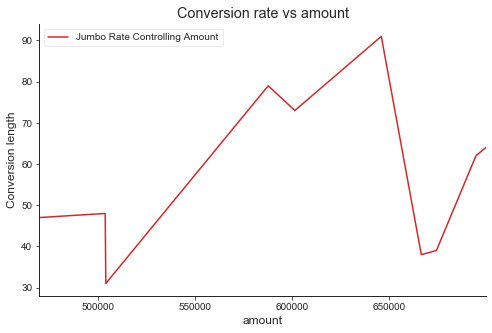

In [27]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(8,5))
jumbo_amount_df_conversion_rate.plot(kind='line',color=red)
ax.set_ylabel("Conversion length")
ax.legend(["Jumbo Rate Controlling Amount"])
ax.set_title("Conversion rate vs amount")
ax.set_xlim([jumbo_amount_df_conversion_rate.index[0], jumbo_amount_df_conversion_rate.index[-1]])
sns.despine()
plt.show()

# Conversion length is higher for larger amounts as expected since jumbo loans are for loans exceeding county limits.

In [28]:
trend_state_df = merge_df[["State","funded", "conversion_length_d", "jumbo"]]
trend_state_df = trend_state_df.sort_values("funded",ascending=True)
trend_state_df.set_index("funded", inplace=True)
trend_state_df.head()

,State,conversion_length_d,jumbo
funded,,,
2016-10-26,CA,30.000,False
2016-10-26,CA,44.000,False
2016-10-26,CA,49.000,False
2016-10-26,CA,62.000,False
2016-10-26,CA,60.000,False


In [29]:
jumbo_state_df = trend_state_df[trend_state_df["jumbo"]]
jumbo_state_df.drop("jumbo", axis=1, inplace=True)
jumbo_state_df.index = pd.to_datetime(jumbo_amount_df.index, format="%Y-%m-%d", errors="coerce")
jumbo_state_df.head()

,State,conversion_length_d
funded,,
2017-02-24,CA,39.000
2017-04-24,OR,47.000
2017-07-13,GA,48.000
2017-07-26,WA,38.000
2017-09-18,GA,31.000


In [30]:
jumbo_state_df.State.unique()

array(['CA', 'OR', 'GA', 'WA', 'CT', 'NC'], dtype=object)

In [31]:
jumbo_state_conversion_rate_df = jumbo_state_df.groupby(["State","funded"])["conversion_length_d"].count()
jumbo_state_conversion_rate_df.head()

State  funded    
CA     2017-02-24    1
       2017-09-22    1
       2017-12-05    1
CT     2017-11-02    1
GA     2017-07-13    1
Name: conversion_length_d, dtype: int64

In [32]:
grouper = jumbo_state_df.groupby([pd.Grouper(freq="D"), "State"])
conversion_rate_state_df = grouper["conversion_length_d"].count().unstack().fillna(0)
conversion_rate_state_df.head()

State,CA,CT,GA,NC,OR,WA
funded,,,,,,
2017-02-24,1.000,0.000,0.000,0.000,0.000,0.000
2017-04-24,0.000,0.000,0.000,0.000,1.000,0.000
2017-07-13,0.000,0.000,1.000,0.000,0.000,0.000
2017-07-26,0.000,0.000,0.000,0.000,0.000,1.000
2017-09-18,0.000,0.000,1.000,0.000,0.000,0.000
